# Taper Before/After Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import cwt, morlet
from scipy.signal import periodogram
from scipy.interpolate import interp1d

In [2]:
TABLES_DIRECTORY = "../../Data/giant_tables"
TAPER_THRESHOLD = 0.5
DURATION_HOURS = 24 * 3

In [3]:
patient_hup_ids = []
# Iterate through all files in TABLES_DIRECTORY
for filename in os.listdir(TABLES_DIRECTORY):
    # Only look at filename that are .csv files and does not begin with .
    if filename.endswith(".csv") and not filename.startswith("."):
        # Get the patient_hup_id from the filename which is after _ and before .
        patient_hup_id = int(filename.split("_")[1].split(".")[0])
        patient_hup_ids.append(patient_hup_id)

patient_hup_ids = sorted(patient_hup_ids)
len(patient_hup_ids)

62

## Plotting function

In [16]:
def plot_stuff(hourly_patient_features_df, before_taper_period, after_taper_period):
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    fig, ax = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

    # Plotting Individual ASMs
    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax[0].plot(hourly_patient_features_df["emu_hour"], normalized_data)

    # Adding horizontal bars
    ax[0].hlines(
        1, before_taper_period[0], before_taper_period[1], color="green", linewidth=2
    )
    ax[0].hlines(
        1, after_taper_period[0], after_taper_period[1], color="red", linewidth=2
    )

    # Adding text annotations
    ax[0].text(
        (before_taper_period[0] + before_taper_period[1]) / 2,
        1,
        "before taper",
        ha="center",
        va="bottom",
    )
    ax[0].text(
        (after_taper_period[0] + after_taper_period[1]) / 2,
        1,
        "after taper",
        ha="center",
        va="bottom",
    )

    seizure_hours = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] >= 1
    ]["emu_hour"].values
    for idx in seizure_hours:
        ax[0].axvline(x=idx, color="red", linestyle="dotted")

    ax[0].set_ylabel("Load")
    ax[0].set_ylim([0, 1.3])
    ax[0].set_title("Individual ASMs")

    # Plotting Teager Energy (delta Band)
    ax[1].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["teager_energy_delta"],
    )
    ax[1].set_ylabel("Teager Energy")
    ax[1].set_title("Teager Energy (delta Band)")

    # Plotting Kuramoto (delta Band)
    ax[2].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["kuramoto_delta"],
    )
    ax[2].set_ylabel("R")
    ax[2].set_title("Synchrony (delta Band)")

    ax[2].set_xlabel("Time (hours)")

    plt.tight_layout()
    plt.show()

In [17]:
def plot_periodogram_for_patient(patient_hup_id):
    frequency_bands = ["delta", "theta", "alpha", "beta", "gamma"]

    # Define the common periods in hours
    common_periods = np.linspace(1, 48, 1000)

    # Convert to frequencies
    common_frequencies = 1 / common_periods

    # Create a figure with 2 rows and 5 columns
    fig, axs = plt.subplots(2, 5, figsize=[30, 6])

    for idx, frequency_band in enumerate(frequency_bands):
        # Read in the giant table for this patient
        hourly_patient_features_df = pd.read_csv(
            os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
        )
        (before_taper_period, after_taper_period) = find_taper_periods(
            hourly_patient_features_df, patient_hup_id
        )

        # Extract before and after taper periods
        before_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < before_taper_period[1]),
            f"kuramoto_{frequency_band}",
        ]
        after_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
            f"kuramoto_{frequency_band}",
        ]

        # Interpolate nan values
        before_taper = before_taper.interpolate()
        after_taper = after_taper.interpolate()

        # Calculate periodogram for before and after taper
        frequencies_before, pgram_before = periodogram(before_taper, fs=1)
        frequencies_after, pgram_after = periodogram(after_taper, fs=1)

        # Interpolate the periodograms to the common frequencies
        interp_before = interp1d(
            frequencies_before,
            pgram_before,
            kind="linear",
            bounds_error=False,
            fill_value=0.0,
        )
        interp_after = interp1d(
            frequencies_after,
            pgram_after,
            kind="linear",
            bounds_error=False,
            fill_value=0.0,
        )

        # Plotting Before Taper
        axs[0, idx].plot(
            common_periods, interp_before(common_frequencies), label="Before Taper"
        )
        axs[0, idx].set_ylabel("Power")
        axs[0, idx].set_title(f"Before Taper - {frequency_band.capitalize()} Band")

        # Plotting After Taper
        axs[1, idx].plot(
            common_periods, interp_after(common_frequencies), label="After Taper"
        )
        axs[1, idx].set_xlabel("Period (hours)")
        axs[1, idx].set_ylabel("Power")
        axs[1, idx].set_title(f"After Taper - {frequency_band.capitalize()} Band")

        # Label on the x axis when it's 4 and 24 hours
        axs[0, idx].set_xticks([4, 24])
        axs[0, idx].set_xticklabels(["4", "24"])
        axs[1, idx].set_xticks([4, 24])
        axs[1, idx].set_xticklabels(["4", "24"])

        # Also label the rest of the hours
        axs[0, idx].set_xticks(np.arange(1, 48, 1), minor=True)
        axs[1, idx].set_xticks(np.arange(1, 48, 1), minor=True)

        # Get the y-axis limits from the "before taper" subplot for this frequency band
        ylim = axs[0, idx].get_ylim()

        # Apply the same y-axis limits to the "after taper" subplot for this frequency band
        axs[1, idx].set_ylim(ylim)

    # plt.tight_layout()
    plt.suptitle(f"Patient {patient_hup_id} - 3 days", fontsize=16)
    plt.show()

## Find taper period function

In [18]:
def find_taper_periods(hourly_patient_features_df, patient_hup_id):
    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Find the first 'emu_hour' where both 'teager_energy' and 'kuramoto' are not nan
    start_point = hourly_patient_features_df[
        (~hourly_patient_features_df["teager_energy_delta"].isna())
        & (~hourly_patient_features_df["kuramoto_delta"].isna())
    ].emu_hour.min()

    # Check the length of the  kuramoto_delta column after dropping nan. if the length is less than 192
    # then the patient does not have enough data to be analyzed
    if (
        len(
            hourly_patient_features_df[
                (~hourly_patient_features_df["kuramoto_delta"].isna())
            ]
        )
        < DURATION_HOURS * 2 + 48
    ):
        print(
            f"Patient {patient_hup_id} does not have enough data to be analyzed. Skipping..."
        )
        return (np.nan, np.nan), (np.nan, np.nan)

    before_taper_period = (start_point, start_point + DURATION_HOURS)
    after_taper_period = (
        start_point + DURATION_HOURS + 24,
        start_point + DURATION_HOURS + 24 + DURATION_HOURS,
    )

    if patient_hup_id in [145, 160, 216]:
        after_taper_period = (
            start_point + DURATION_HOURS + 48,
            start_point + DURATION_HOURS + 48 + DURATION_HOURS,
        )

    if patient_hup_id in [143, 146, 153, 207]:
        # 3 days is 72 hours
        after_taper_period = (
            start_point + DURATION_HOURS + 72,
            start_point + DURATION_HOURS + 72 + DURATION_HOURS,
        )

    if patient_hup_id in [142, 179]:
        # 96 hours is 4 days
        after_taper_period = (
            start_point + DURATION_HOURS + 96,
            start_point + DURATION_HOURS + 96 + DURATION_HOURS,
        )

    if patient_hup_id in [193]:
        # 5 days is 120 hours
        after_taper_period = (
            start_point + DURATION_HOURS + 120,
            start_point + DURATION_HOURS + 120 + DURATION_HOURS,
        )

    if patient_hup_id in [165, 209, 213]:
        # 144 hours is 6 days
        after_taper_period = (
            start_point + DURATION_HOURS + 144,
            start_point + DURATION_HOURS + 144 + DURATION_HOURS,
        )

    if patient_hup_id in [197]:
        # 8 days is 192 hours
        after_taper_period = (
            start_point + DURATION_HOURS + 192,
            start_point + DURATION_HOURS + 192 + DURATION_HOURS,
        )

    return before_taper_period, after_taper_period

## Plot all time series

Patient 138 does not have enough data to be analyzed. Skipping...
Patient 138 has nan values in before_taper_period or after_taper_period
Patient 140 does not have enough data to be analyzed. Skipping...
Patient 140 has nan values in before_taper_period or after_taper_period
Patient 141 does not have enough data to be analyzed. Skipping...
Patient 141 has nan values in before_taper_period or after_taper_period
Patient 142 before taper period: (36, 108) after taper period: (204, 276)


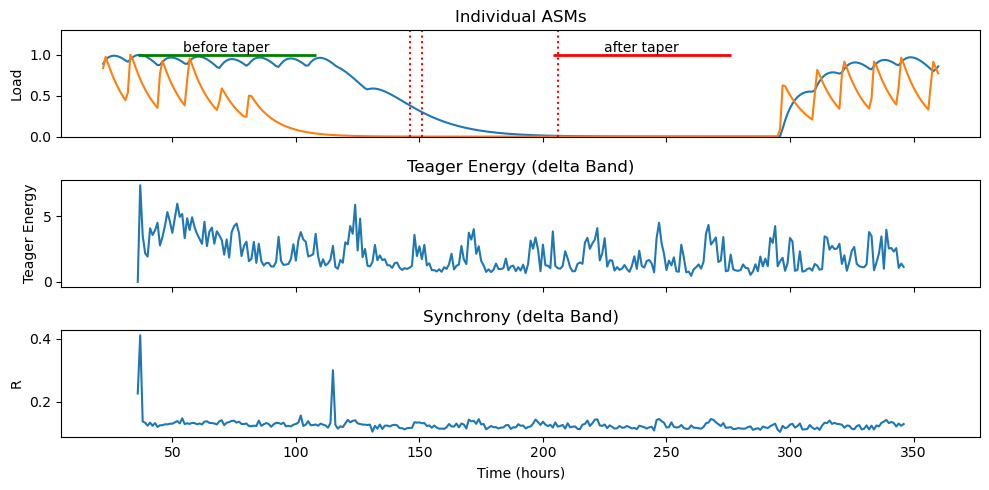

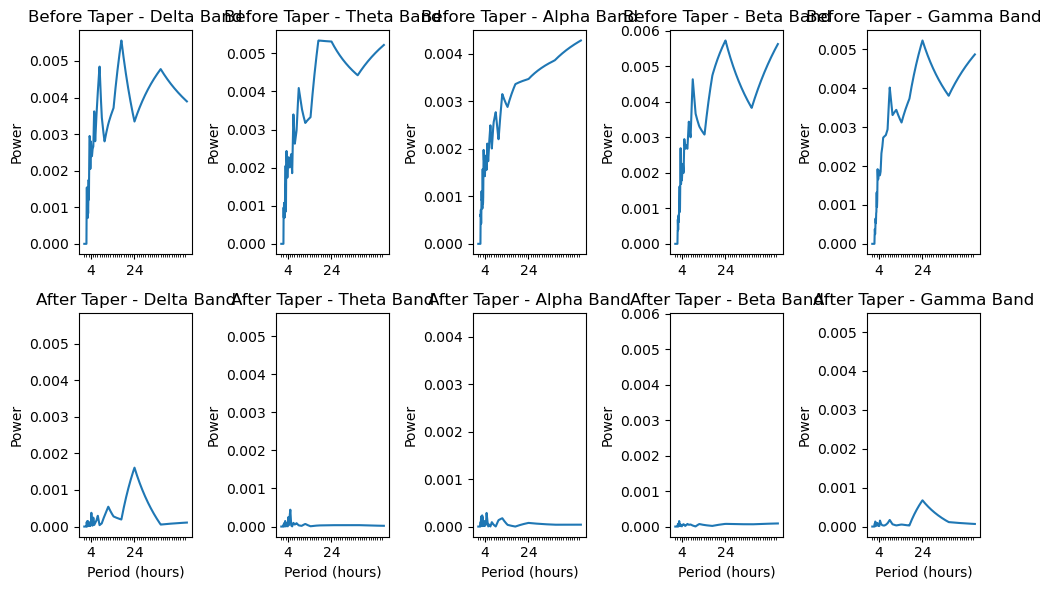

Patient 143 before taper period: (42, 114) after taper period: (186, 258)


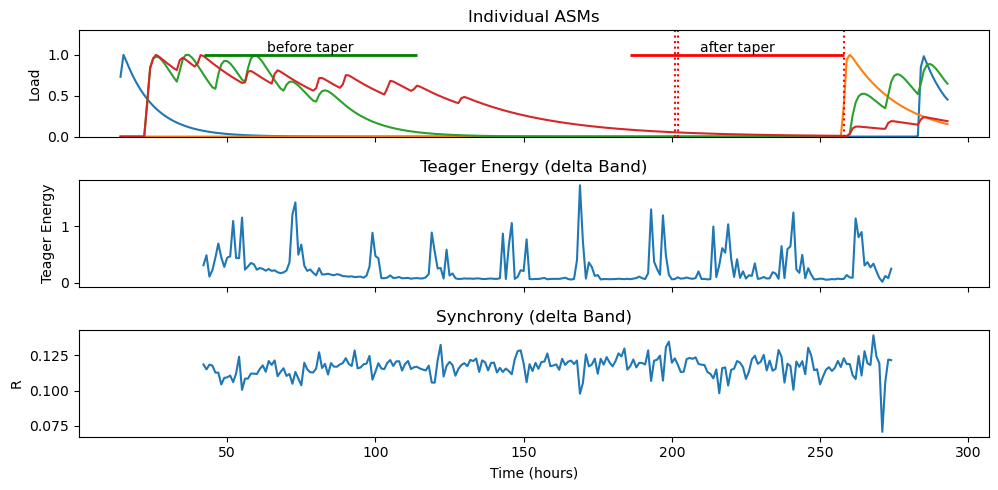

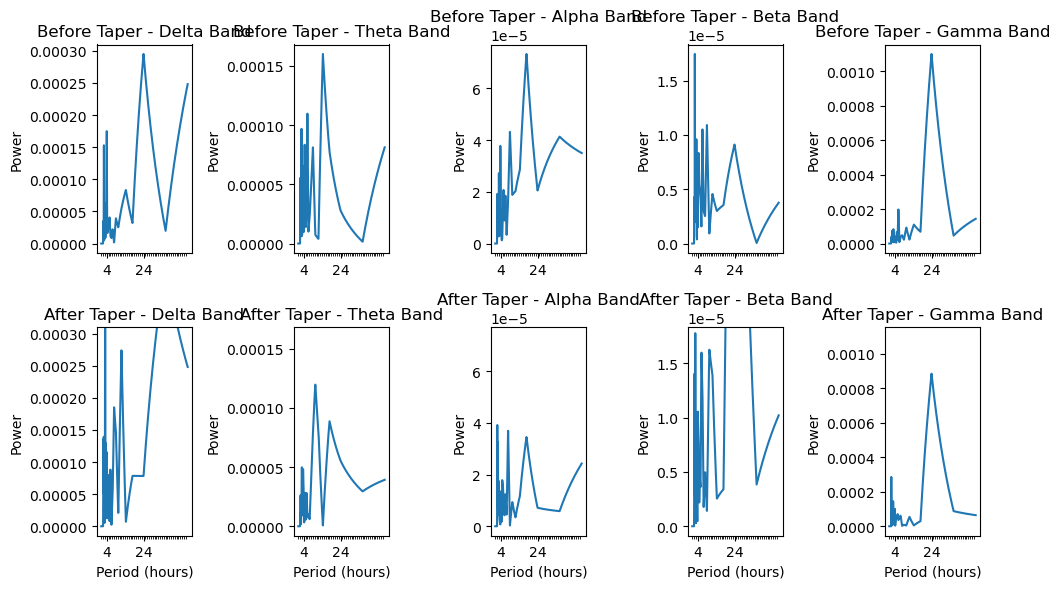

Patient 144 does not have enough data to be analyzed. Skipping...
Patient 144 has nan values in before_taper_period or after_taper_period
Patient 145 before taper period: (38, 110) after taper period: (158, 230)


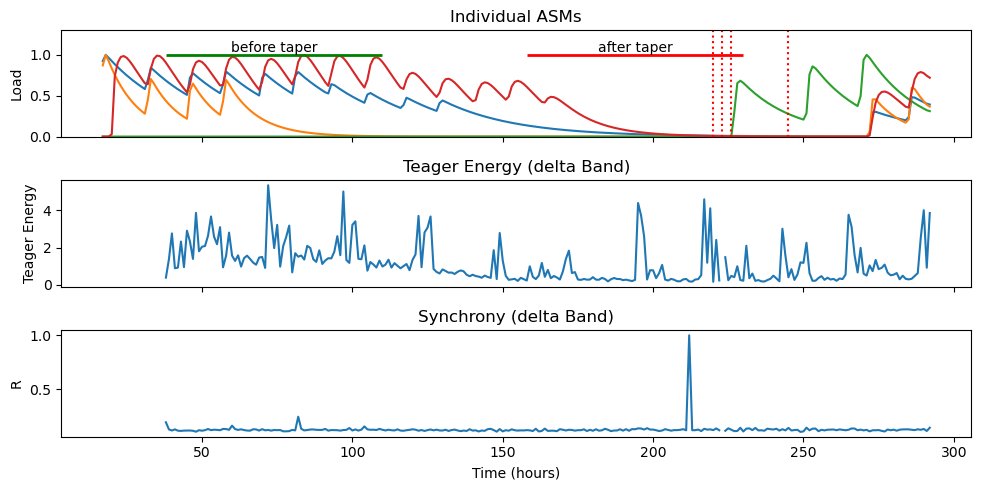

KeyboardInterrupt: 

In [19]:
good_hup_ids = []

for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    (
        before_taper_period,
        after_taper_period,
    ) = find_taper_periods(hourly_patient_features_df, patient_hup_id)

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if (
        np.isnan(before_taper_period[0])
        or np.isnan(before_taper_period[1])
        or np.isnan(after_taper_period[0])
        or np.isnan(after_taper_period[1])
    ):
        print(
            f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
        )
        continue

    print(
        f"Patient {patient_hup_id} before taper period: {before_taper_period} after taper period: {after_taper_period}"
    )
    plot_stuff(hourly_patient_features_df, before_taper_period, after_taper_period)
    plot_periodogram_for_patient(patient_hup_id)
    good_hup_ids.append(patient_hup_id)

In [ ]:
len(good_hup_ids)

## Each patient

In [ ]:
# frequency_bands = ["delta", "theta", "alpha", "beta", "gamma"]


# for patient_hup_id in good_hup_ids:
#     # Read in the giant table for this patient
#     hourly_patient_features_df = pd.read_csv(
#         os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
#     )
#     (
#         before_taper_period,
#         after_taper_period,
#     ) = find_taper_periods(hourly_patient_features_df, patient_hup_id)

#     fig, ax = plt.subplots(
#         len(frequency_bands) + 1,
#         2,
#         figsize=(15, 20),
#         gridspec_kw={"height_ratios": [1] + [3] * len(frequency_bands)},
#     )

#     ###############################
#     # ASM
#     ###############################

#     # Extract before and after taper periods for medication data
#     before_taper_medication = hourly_patient_features_df.loc[
#         (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
#         & (hourly_patient_features_df["emu_hour"] < before_taper_period[1])
#     ]

#     after_taper_medication = hourly_patient_features_df.loc[
#         (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
#         & (hourly_patient_features_df["emu_hour"] < after_taper_period[1])
#     ]

#     # Assert the length of before and after taper periods are both a multiple of 24
#     assert len(before_taper_medication) == DURATION_HOURS
#     assert len(after_taper_medication) == DURATION_HOURS

#     # Extracting medication columns
#     med_cols = [
#         col
#         for col in hourly_patient_features_df.columns
#         if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
#     ]
#     med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

#     # Plotting before taper medication data
#     for col in med_cols:
#         if col != "med_sum_no_lorazepam_raw":
#             normalized_data = (
#                 before_taper_medication[col] / hourly_patient_features_df[col].max()
#             )
#             ax[0, 0].plot(before_taper_medication["emu_hour"], normalized_data)

#     ax[0, 0].set_ylim([0, 1.3])
#     ax[0, 0].set_ylabel("ASM Load")
#     ax[0, 0].set_title("Before Taper")

#     # Plotting after taper medication data
#     for col in med_cols:
#         if col != "med_sum_no_lorazepam_raw":
#             normalized_data = (
#                 after_taper_medication[col] / hourly_patient_features_df[col].max()
#             )
#             ax[0, 1].plot(before_taper_medication["emu_hour"], normalized_data)

#     ax[0, 1].set_ylim([0, 1.3])
#     ax[0, 1].set_title("After Taper")

#     ###############################
#     # Wavelet Transform
#     ###############################
#     widths = np.arange(1, 49)  # Ranging up to 48 hours
#     # Iterate through each frequency band and plot the corresponding wavelet transforms
#     for idx, band in enumerate(frequency_bands):
#         # Get the 'band' rows within the before and after taper periods
#         before_taper = hourly_patient_features_df.loc[
#             (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
#             & (hourly_patient_features_df["emu_hour"] < before_taper_period[1]),
#             f"kuramoto_{band}",
#         ]
#         after_taper = hourly_patient_features_df.loc[
#             (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
#             & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
#             f"kuramoto_{band}",
#         ]

#         # Interpolate nan values
#         before_taper = before_taper.interpolate()
#         after_taper = after_taper.interpolate()

#         # Perform wavelet transform
#         before_cwt_transform = cwt(before_taper.values, morlet, widths)
#         after_cwt_transform = cwt(after_taper.values, morlet, widths)

#         # Plotting the wavelet transform for before taper
#         cax_before = ax[idx + 1, 0].imshow(
#             np.abs(before_cwt_transform),
#             extent=[0, DURATION_HOURS, 1, 48],
#             aspect="auto",
#             interpolation="bilinear",
#             cmap="jet",
#         )
#         ax[idx + 1, 0].set_ylabel(f"{band.capitalize()} Period (hours)")
#         if idx == len(frequency_bands) - 1:
#             ax[idx + 1, 0].set_xlabel("Time (hours)")

#         # Plotting the wavelet transform for after taper
#         cax_after = ax[idx + 1, 1].imshow(
#             np.abs(after_cwt_transform),
#             extent=[0, DURATION_HOURS, 1, 48],
#             aspect="auto",
#             interpolation="bilinear",
#             cmap="jet",
#         )
#         if idx == len(frequency_bands) - 1:
#             ax[idx + 1, 1].set_xlabel("Time (hours)")

#     plt.suptitle(f"HUP {patient_hup_id}")
#     plt.tight_layout(
#         rect=[0, 0, 1, 0.96]
#     )  # Adjusting layout to accommodate the main title
#     plt.show()

## All patients

In [ ]:
# frequency_bands = ["delta", "theta", "alpha", "beta", "gamma"]
# widths = np.arange(1, 49)  # Ranging up to 48 hours

# # Initialize matrices to store summed wavelet transform results for before and after periods
# sum_before_cwt = {
#     band: np.zeros((len(widths), DURATION_HOURS)) for band in frequency_bands
# }
# sum_after_cwt = {
#     band: np.zeros((len(widths), DURATION_HOURS)) for band in frequency_bands
# }

# # Iterate through each patient to calculate the wavelet transform
# for patient_hup_id in good_hup_ids:
#     # Read in the giant table for this patient
#     hourly_patient_features_df = pd.read_csv(
#         os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
#     )
#     (
#         before_taper_period,
#         after_taper_period,
#     ) = find_taper_periods(hourly_patient_features_df, patient_hup_id)

#     # Iterate through each frequency band and calculate the corresponding wavelet transforms
#     for band in frequency_bands:
#         # Extract before and after taper periods
#         before_taper = hourly_patient_features_df.loc[
#             (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
#             & (hourly_patient_features_df["emu_hour"] < before_taper_period[1]),
#             f"kuramoto_{band}",
#         ]
#         after_taper = hourly_patient_features_df.loc[
#             (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
#             & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
#             f"kuramoto_{band}",
#         ]

#         # Interpolate nan values
#         before_taper = before_taper.interpolate()
#         after_taper = after_taper.interpolate()

#         # Perform wavelet transform
#         before_cwt_transform = cwt(before_taper.values, morlet, widths)
#         after_cwt_transform = cwt(after_taper.values, morlet, widths)

#         # Normalize by dividing by the maximum absolute value
#         before_cwt_transform /= np.max(np.abs(before_cwt_transform))
#         after_cwt_transform /= np.max(np.abs(after_cwt_transform))

#         # Add the absolute values to the sum
#         sum_before_cwt[band] += np.abs(before_cwt_transform)
#         sum_after_cwt[band] += np.abs(after_cwt_transform)


# # Calculate averages by dividing by the number of patients
# avg_before_cwt = {
#     band: cwt_sum / len(good_hup_ids) for band, cwt_sum in sum_before_cwt.items()
# }
# avg_after_cwt = {
#     band: cwt_sum / len(good_hup_ids) for band, cwt_sum in sum_after_cwt.items()
# }

# # Plot averaged wavelet transforms for each frequency band
# fig, ax = plt.subplots(len(frequency_bands), 2, figsize=(15, 20))
# for idx, band in enumerate(frequency_bands):
#     cax_before = ax[idx, 0].imshow(
#         avg_before_cwt[band],
#         extent=[0, DURATION_HOURS, 1, 48],
#         aspect="auto",
#         interpolation="bilinear",
#         cmap="jet",
#     )
#     fig.colorbar(cax_before, ax=ax[idx, 0])
#     ax[idx, 0].set_ylabel(f"{band.capitalize()} Period (hours)")
#     if idx == len(frequency_bands) - 1:
#         ax[idx, 0].set_xlabel("Time (hours)")

#     cax_after = ax[idx, 1].imshow(
#         avg_after_cwt[band],
#         extent=[0, DURATION_HOURS, 1, 48],
#         aspect="auto",
#         interpolation="bilinear",
#         cmap="jet",
#     )
#     fig.colorbar(cax_after, ax=ax[idx, 1])
#     if idx == len(frequency_bands) - 1:
#         ax[idx, 1].set_xlabel("Time (hours)")

# # Add titles to the columns
# ax[0, 0].set_title("Before Taper")
# ax[0, 1].set_title("After Taper")

# plt.tight_layout()
# plt.show()

## Periodogram 3 days

In [ ]:
DURATION_HOURS = 24 * 3

frequency_bands = ["delta", "theta", "alpha", "beta", "gamma"]

# Define the common periods in hours
common_periods = np.linspace(1, 48, 1000)

# Convert to frequencies
common_frequencies = 1 / common_periods

for frequency_band in frequency_bands:
    # Lists to store all periodograms
    periodograms_before_taper = []
    periodograms_after_taper = []

    for patient_hup_id in good_hup_ids:
        # Read in the giant table for this patient
        hourly_patient_features_df = pd.read_csv(
            os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
        )
        (before_taper_period, after_taper_period) = find_taper_periods(
            hourly_patient_features_df, patient_hup_id
        )

        # Extract before and after taper periods
        before_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < before_taper_period[1]),
            f"kuramoto_{frequency_band}",
        ]
        after_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
            f"kuramoto_{frequency_band}",
        ]

        # Interpolate nan values
        before_taper = before_taper.interpolate()
        after_taper = after_taper.interpolate()

        # Calculate periodogram for before and after taper
        frequencies_before, pgram_before = periodogram(before_taper, fs=1)
        frequencies_after, pgram_after = periodogram(after_taper, fs=1)

        # Interpolate the periodograms to the common frequencies
        interp_before = interp1d(
            frequencies_before,
            pgram_before,
            kind="linear",
            bounds_error=False,
            fill_value=0.0,
        )
        interp_after = interp1d(
            frequencies_after,
            pgram_after,
            kind="linear",
            bounds_error=False,
            fill_value=0.0,
        )

        # Add periodograms to the lists
        periodograms_before_taper.append(interp_before(common_frequencies))
        periodograms_after_taper.append(interp_after(common_frequencies))

    # Convert lists to numpy arrays
    periodograms_before_taper = np.array(periodograms_before_taper)
    periodograms_after_taper = np.array(periodograms_after_taper)

    # Calculate average and standard deviation
    mean_before = np.mean(periodograms_before_taper, axis=0)
    std_before = np.std(periodograms_before_taper, axis=0)
    mean_after = np.mean(periodograms_after_taper, axis=0)
    std_after = np.std(periodograms_after_taper, axis=0)

    # ... Previous code

    # Plotting the results
    fig, axs = plt.subplots(2, 1, figsize=[6, 6])

    # Plotting Before Taper
    axs[0].plot(common_periods, mean_before, label="Before Taper")
    axs[0].fill_between(
        common_periods, mean_before - std_before, mean_before + std_before, alpha=0.2
    )
    axs[0].set_ylabel("Power")
    axs[0].set_title(f"Before Taper - {frequency_band.capitalize()} Band - 3 days")

    # Plotting After Taper
    axs[1].plot(common_periods, mean_after, label="After Taper")
    axs[1].fill_between(
        common_periods, mean_after - std_after, mean_after + std_after, alpha=0.2
    )
    axs[1].set_xlabel("Period (hours)")
    axs[1].set_ylabel("Power")
    axs[1].set_title(f"After Taper - {frequency_band.capitalize()} Band - 3 days")

    # Label on the x axis when it's 4 and 24 hours
    axs[0].set_xticks([4, 24])
    axs[0].set_xticklabels(["4", "24"])

    # Also label the rest of the hours
    axs[0].set_xticks(np.arange(1, 48, 1), minor=True)

    # Get the y-axis limits from the first subplot (before taper)
    ylim = axs[0].get_ylim()

    # Apply the same y-axis limits to the second subplot (after taper)
    axs[1].set_ylim(ylim)

    plt.tight_layout()
    plt.show()

In [ ]:
# frequency_bands = ["delta", "theta", "alpha", "beta", "gamma"]

# # Define the common periods in hours
# common_periods = np.linspace(1, 48, 1000)

# # Convert to frequencies
# common_frequencies = 1 / common_periods

# for patient_hup_id in good_hup_ids:
#     # Create a figure with 2 rows and 5 columns
#     fig, axs = plt.subplots(2, 5, figsize=[30, 6])

#     for idx, frequency_band in enumerate(frequency_bands):
#         # Read in the giant table for this patient
#         hourly_patient_features_df = pd.read_csv(
#             os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
#         )
#         (before_taper_period, after_taper_period) = find_taper_periods(
#             hourly_patient_features_df, patient_hup_id
#         )

#         # Extract before and after taper periods
#         before_taper = hourly_patient_features_df.loc[
#             (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
#             & (hourly_patient_features_df["emu_hour"] < before_taper_period[1]),
#             f"kuramoto_{frequency_band}",
#         ]
#         after_taper = hourly_patient_features_df.loc[
#             (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
#             & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
#             f"kuramoto_{frequency_band}",
#         ]

#         # Interpolate nan values
#         before_taper = before_taper.interpolate()
#         after_taper = after_taper.interpolate()

#         # Calculate periodogram for before and after taper
#         frequencies_before, pgram_before = periodogram(before_taper, fs=1)
#         frequencies_after, pgram_after = periodogram(after_taper, fs=1)

#         # Interpolate the periodograms to the common frequencies
#         interp_before = interp1d(
#             frequencies_before,
#             pgram_before,
#             kind="linear",
#             bounds_error=False,
#             fill_value=0.0,
#         )
#         interp_after = interp1d(
#             frequencies_after,
#             pgram_after,
#             kind="linear",
#             bounds_error=False,
#             fill_value=0.0,
#         )

#         # Plotting Before Taper
#         axs[0, idx].plot(
#             common_periods, interp_before(common_frequencies), label="Before Taper"
#         )
#         axs[0, idx].set_ylabel("Power")
#         axs[0, idx].set_title(f"Before Taper - {frequency_band.capitalize()} Band")

#         # Plotting After Taper
#         axs[1, idx].plot(
#             common_periods, interp_after(common_frequencies), label="After Taper"
#         )
#         axs[1, idx].set_xlabel("Period (hours)")
#         axs[1, idx].set_ylabel("Power")
#         axs[1, idx].set_title(f"After Taper - {frequency_band.capitalize()} Band")

#         # Label on the x axis when it's 4 and 24 hours
#         axs[0, idx].set_xticks([4, 24])
#         axs[0, idx].set_xticklabels(["4", "24"])
#         axs[1, idx].set_xticks([4, 24])
#         axs[1, idx].set_xticklabels(["4", "24"])

#         # Also label the rest of the hours
#         axs[0, idx].set_xticks(np.arange(1, 48, 1), minor=True)
#         axs[1, idx].set_xticks(np.arange(1, 48, 1), minor=True)

#         # Get the y-axis limits from the "before taper" subplot for this frequency band
#         ylim = axs[0, idx].get_ylim()

#         # Apply the same y-axis limits to the "after taper" subplot for this frequency band
#         axs[1, idx].set_ylim(ylim)

#     # plt.tight_layout()
#     plt.suptitle(f"Patient {patient_hup_id} - 3 days", fontsize=16)
#     plt.show()

## Periodogram 5 days

In [ ]:
DURATION_HOURS = 24 * 5

frequency_bands = ["delta", "theta", "alpha", "beta", "gamma"]

# Define the common periods in hours
common_periods = np.linspace(1, 48, 1000)

# Convert to frequencies
common_frequencies = 1 / common_periods

for frequency_band in frequency_bands:
    # Lists to store all periodograms
    periodograms_before_taper = []
    periodograms_after_taper = []

    for patient_hup_id in good_hup_ids:
        # Read in the giant table for this patient
        hourly_patient_features_df = pd.read_csv(
            os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
        )
        (before_taper_period, after_taper_period) = find_taper_periods(
            hourly_patient_features_df, patient_hup_id
        )

        # Extract before and after taper periods
        before_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < before_taper_period[1]),
            f"kuramoto_{frequency_band}",
        ]
        after_taper = hourly_patient_features_df.loc[
            (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
            & (hourly_patient_features_df["emu_hour"] < after_taper_period[1]),
            f"kuramoto_{frequency_band}",
        ]

        # Interpolate nan values
        before_taper = before_taper.interpolate()
        after_taper = after_taper.interpolate()

        # Calculate periodogram for before and after taper
        frequencies_before, pgram_before = periodogram(before_taper, fs=1)
        frequencies_after, pgram_after = periodogram(after_taper, fs=1)

        # Interpolate the periodograms to the common frequencies
        interp_before = interp1d(
            frequencies_before,
            pgram_before,
            kind="linear",
            bounds_error=False,
            fill_value=0.0,
        )
        interp_after = interp1d(
            frequencies_after,
            pgram_after,
            kind="linear",
            bounds_error=False,
            fill_value=0.0,
        )

        # Add periodograms to the lists
        periodograms_before_taper.append(interp_before(common_frequencies))
        periodograms_after_taper.append(interp_after(common_frequencies))

    # Convert lists to numpy arrays
    periodograms_before_taper = np.array(periodograms_before_taper)
    periodograms_after_taper = np.array(periodograms_after_taper)

    # Calculate average and standard deviation
    mean_before = np.mean(periodograms_before_taper, axis=0)
    std_before = np.std(periodograms_before_taper, axis=0)
    mean_after = np.mean(periodograms_after_taper, axis=0)
    std_after = np.std(periodograms_after_taper, axis=0)

    # Plotting the results
    fig, axs = plt.subplots(2, 1, figsize=[6, 6])

    # Plotting Before Taper
    axs[0].plot(common_periods, mean_before, label="Before Taper")
    axs[0].fill_between(
        common_periods, mean_before - std_before, mean_before + std_before, alpha=0.2
    )
    axs[0].set_ylabel("Power")
    axs[0].set_title(f"Before Taper - {frequency_band.capitalize()} Band - 3 days")

    # Plotting After Taper
    axs[1].plot(common_periods, mean_after, label="After Taper")
    axs[1].fill_between(
        common_periods, mean_after - std_after, mean_after + std_after, alpha=0.2
    )
    axs[1].set_xlabel("Period (hours)")
    axs[1].set_ylabel("Power")
    axs[1].set_title(f"After Taper - {frequency_band.capitalize()} Band - 3 days")

    # Label on the x axis when it's 4 and 24 hours
    axs[0].set_xticks([4, 24])
    axs[0].set_xticklabels(["4", "24"])

    # Also label the rest of the hours
    axs[0].set_xticks(np.arange(1, 48, 1), minor=True)

    plt.tight_layout()
    plt.show()